Source: https://covid19.healthdata.org/global?view=total-deaths&tab=trend
Vaccinations of Germany: https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Impfquoten-Tab.html

Some important KPIs https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import datetime




pd.set_option("display.max.rows",None)

In [2]:
path='D:/DataSets/Corona/World'

df_best_masks_hosp=pd.read_csv(path+str('/best_masks_hospitalization_all_locs.csv'))
df_new_variant=pd.read_csv(path+str('/new_variant_hospitalization_all_locs.csv'))
df_reference_hospitalization=pd.read_csv(path+str('/reference_hospitalization_all_locs.csv'))
df_summary=pd.read_csv(path+str('/Summary_stats_all_locs.csv'))
df_worse_hospitalization=pd.read_csv(path+str('/worse_hospitalization_all_locs.csv'))

D:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,50) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
D:\Users\sebas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (43,72) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Here Comes some  functions to use in the report

In [3]:
list_of_country=[]
for i in df_best_masks_hosp['location_name'].unique():
    list_of_country.append(i)
#print(sorted(list_of_country))

In [4]:
def lineplot_func(data,x,y,title=None,hue=None):
    
    if data[x].dtypes=='object':
        x=pd.to_datetime(data[x])
    
    fig,ax=plt.subplots(figsize=(10,5))
    fig=sns.lineplot(data=data
                     ,x=x
                     ,y=y
                     ,estimator=sum
                     ,ci=None
                     ,hue=hue)
    plt.title(title)

In [5]:
df_ref_hos_ger=df_reference_hospitalization.loc[df_reference_hospitalization['location_name']=='Germany']
df_ref_hos_ger['date']=pd.to_datetime(df_ref_hos_ger['date'])

<ipython-input-5-6d6a511ba356>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_hos_ger['date']=pd.to_datetime(df_ref_hos_ger['date'])


# Reference hospitalization

In [6]:
print(df_ref_hos_ger.shape)
df_ref_hos_ger.columns[df_ref_hos_ger.isna().any()].tolist()

(514, 73)


['mobility_data_type',
 'mobility_composite',
 'confirmed_infections_data_type',
 'confirmed_infections',
 'confirmed_infections_p100k_rate',
 'seroprev_mean',
 'seroprev_upper',
 'seroprev_lower',
 'seroprev_data_type']

<AxesSubplot:>

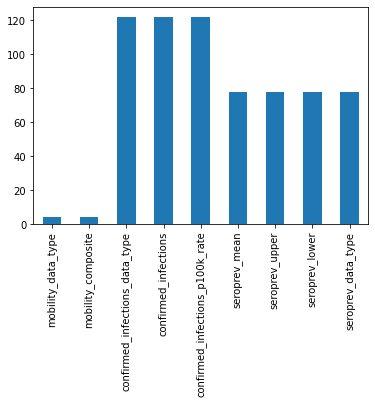

In [7]:
null_values=df_ref_hos_ger.isna().sum()
null_values=null_values[null_values>0]
null_values.plot(kind='bar')

In [8]:
print(null_values)
print(null_values.dtypes)

mobility_data_type                   4
mobility_composite                   4
confirmed_infections_data_type     122
confirmed_infections               122
confirmed_infections_p100k_rate    122
seroprev_mean                       78
seroprev_upper                      78
seroprev_lower                      78
seroprev_data_type                  78
dtype: int64
int64


There are only a few columns with NaNs. These columns pretend to two different types: mobility and confiremt infections.
The sum of NaN is among each column the same (for mobility 4 and for infections 120).
As we´ll need the infections later, we have to handle these missing quantitative values in the Dataframe.


In [9]:
quantitative=[i for i in df_ref_hos_ger.columns if df_ref_hos_ger[i].dtypes!='object']
qualitative=[i for i in df_ref_hos_ger.columns if df_ref_hos_ger[i].dtypes =='object']

In [10]:
#df_quan=df_ref_hos_ger[quantitative]
df_ref_hos_ger[quantitative].columns[df_ref_hos_ger[quantitative].isna().any()].tolist()

['mobility_composite',
 'confirmed_infections',
 'confirmed_infections_p100k_rate',
 'seroprev_mean',
 'seroprev_upper',
 'seroprev_lower']

In [11]:
df_ref_hos_ger[qualitative].columns[df_ref_hos_ger[qualitative].isna().any()].tolist()

['mobility_data_type', 'confirmed_infections_data_type', 'seroprev_data_type']

In [12]:
df_ref_hos_ger[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 25367 to 25880
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   location_name                   514 non-null    object
 1   hosp_data_type                  514 non-null    object
 2   deaths_data_type                514 non-null    object
 3   mobility_data_type              510 non-null    object
 4   total_tests_data_type           514 non-null    object
 5   confirmed_infections_data_type  392 non-null    object
 6   est_infections_data_type        514 non-null    object
 7   seroprev_data_type              436 non-null    object
dtypes: object(8)
memory usage: 36.1+ KB


In [13]:
#ATENTION, becuase I change a bool into a category?
for c in qualitative:
    df_ref_hos_ger[c]=df_ref_hos_ger[c].astype('category')
       
   
    if df_ref_hos_ger[c].isnull().any():      
        df_ref_hos_ger[c] = df_ref_hos_ger[c].cat.add_categories(['MISSING'])  
        df_ref_hos_ger[c] = df_ref_hos_ger[c].fillna('MISSING')                  

<ipython-input-13-08603fa3c14f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_hos_ger[c]=df_ref_hos_ger[c].astype('category')
<ipython-input-13-08603fa3c14f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_hos_ger[c] = df_ref_hos_ger[c].cat.add_categories(['MISSING'])
<ipython-input-13-08603fa3c14f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [14]:
df_ref_hos_ger[qualitative].isna().any()

location_name                     False
hosp_data_type                    False
deaths_data_type                  False
mobility_data_type                False
total_tests_data_type             False
confirmed_infections_data_type    False
est_infections_data_type          False
seroprev_data_type                False
dtype: bool

In [15]:
df_ref_hos_ger[qualitative].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 25367 to 25880
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   location_name                   514 non-null    category
 1   hosp_data_type                  514 non-null    category
 2   deaths_data_type                514 non-null    category
 3   mobility_data_type              514 non-null    category
 4   total_tests_data_type           514 non-null    category
 5   confirmed_infections_data_type  514 non-null    category
 6   est_infections_data_type        514 non-null    category
 7   seroprev_data_type              514 non-null    category
dtypes: category(8)
memory usage: 9.0 KB


In [16]:
for col in quantitative:
    if df_ref_hos_ger[col].isna().any():
        df_ref_hos_ger[col]=df_ref_hos_ger[col].fillna(0)


<ipython-input-16-ebb01a7bb909>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_hos_ger[col]=df_ref_hos_ger[col].fillna(0)


In [17]:
  df_ref_hos_ger[quantitative].columns[df_ref_hos_ger[quantitative].isna().any()].tolist()

[]

As Colums I need for the deaths:
- date
- deaths_data_type
- deaths_upper

I need also check if the deaths_data_type have any proyection into it, because I only want the observed data

In [18]:
df_ref_hos_ger['deaths_data_type'].value_counts()

observed     389
projected    125
Name: deaths_data_type, dtype: int64

As it has projected data, I will filter it more deeply to have only the observed data

In [19]:
df_ref_hos_ger_obs=df_ref_hos_ger[df_ref_hos_ger['deaths_data_type']=='observed']
print(df_ref_hos_ger_obs['deaths_data_type'].value_counts())
max_date=df_ref_hos_ger_obs['date'].max()
print(f'The lates date is: {max_date:%d %B %Y}')

observed     389
projected      0
Name: deaths_data_type, dtype: int64
The lates date is: 26 February 2021


As it the DataFrame only have observed data, we can call the function to draw a lineplot

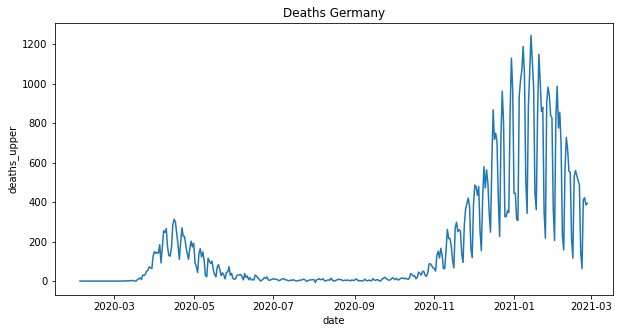

In [20]:
lineplot_func(data=df_ref_hos_ger_obs,x='date',y='deaths_upper',title='Deaths Germany')

Columns I need for the hospitalization:
- hosp_data_type
- allbed_upper -> Beds for Covid needed per day
- ICUbed_upper -> Beds for intensive care of Covid needed per day (ICU=Intensive Care Unit)
- InvVen_upper -> Upper uncertainty bound if invasive ventilation needed by day
- total_tests
- Confirmed_infections

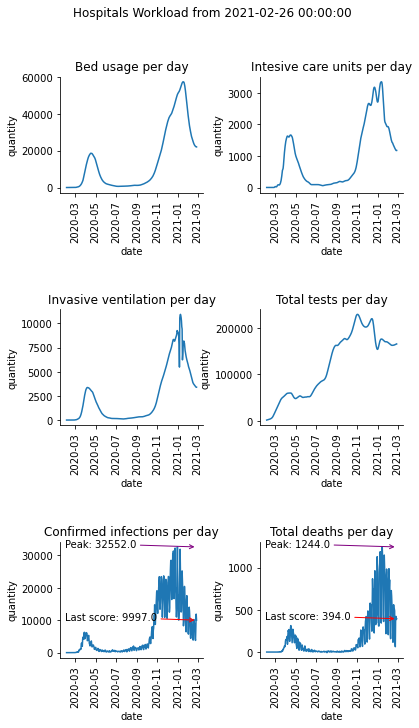

In [21]:
#Using melt for a tidy DataFrame which is more usable for FacetGrid

f=pd.melt(df_ref_hos_ger_obs
          ,value_vars=['allbed_upper'
                       ,'ICUbed_upper'
                       ,'InvVen_upper'
                       ,'total_tests'
                       ,'confirmed_infections'
                       ,'deaths_upper'
                      ]
          ,id_vars='date'
         )



#Plot the FacetGrid
g=sns.FacetGrid(f,col='variable',sharex=False,sharey=False,col_wrap=2)
g=g.map(sns.lineplot,'date','value')

#Change the title of the Subplots
axes=g.axes.flatten()
axes[0].set_title('Bed usage per day')
axes[1].set_title('Intesive care units per day')
axes[2].set_title('Invasive ventilation per day')
axes[3].set_title('Total tests per day')
axes[4].set_title('Confirmed infections per day')
axes[5].set_title('Total deaths per day')

#Make some annotation for better readibility
###ATENTION! Don´t repeat yourself. Try to do this in a loop.
#And further you can put that loop into a funcion to use it later on other data
axes[4].annotate('Last score: {}'.format(np.around(df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])),
                 xy=[
                     df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])
                     ],
                arrowprops={'arrowstyle':'->','color':'red'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['confirmed_infections'].iloc[-1])
                )

axes[5].annotate('Last score: {}'.format(np.around(df_ref_hos_ger_obs['deaths_upper'].iloc[-1])),
                 xy=[
                     df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['deaths_upper'].iloc[-1])
                     ],
                arrowprops={'arrowstyle':'->','color':'red'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['deaths_upper'].iloc[-1])
                )


#Define the peaks of eacht plot
axes[4].annotate('Peak: {}'.format(np.around(df_ref_hos_ger_obs['confirmed_infections'].max())),
                 xy=[df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['confirmed_infections'].max())
                     ],
                arrowprops={'arrowstyle':'->','color':'purple'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['confirmed_infections'].max())
                )

axes[5].annotate('Peak: {}'.format(np.around(df_ref_hos_ger_obs['deaths_upper'].max())),
                 xy=[df_ref_hos_ger_obs['date'].iloc[-1],
                     np.around(df_ref_hos_ger_obs['deaths_upper'].max())
                     ],
                arrowprops={'arrowstyle':'->','color':'purple'},
                xytext=('2020-01-30',df_ref_hos_ger_obs['deaths_upper'].max())
                )




#Change the overall Title and also the x and y axis title on each Subplot. Adjust also the width and the high
g.fig.suptitle('Hospitals Workload from {}'.format(max(df_ref_hos_ger_obs['date'])),y=1.07)
g.set(xlabel='date',ylabel='quantity')
plt.subplots_adjust(hspace=1, wspace=0.4)


#Rotate the x-axis by 90 degree
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

To Improve: Don't repeat yourself, the x-axis on the peak annotation is worng at maximum, becuase the date on the x axis is there where the y axis is max

Number of positive & negative cases per day ----- This would have helped you to compare & find correlation between positive Diagnosed and deaths/recovered. it's called "Fatality ratio" -  It is the ratio of total dead to the total positive case (per day or week) 


"Hospitalization ratio" -It is the ratio of total hospitalized (all cases admitted to hospital) to the total positive cases. 


"Positive case ratio"- It is the ratio of total positive cases to the total number of tests (number of patients appeared for covid test every day/week) 

Date of hospitalization & recovered/discharged date - this would have helped in finding/analysing the number of days taken by a patient to recover from covid infection - questions like - which gender has speedy recovery capability ? - what age group patient has speedy recovery capability?


## Vaccanations


In [22]:
vac=pd.read_excel(path+str('/Vaccanations.xlsx'),sheet_name=3)
vac_headers=['Date','FirstVaccanations','SecoundVaccanations','TotalVaccanations']
vac.drop(vac.tail(3).index,inplace=True)
vac.columns=vac_headers

In [23]:
vac['Date']=pd.to_datetime(vac['Date'])
vac.set_index('Date',inplace=True)


In [24]:
vac.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-12-27 to 2021-03-08
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FirstVaccanations    72 non-null     float64
 1   SecoundVaccanations  72 non-null     float64
 2   TotalVaccanations    72 non-null     float64
dtypes: float64(3)
memory usage: 2.2 KB


In [25]:
#infections_cum=df_ref_hos_ger_obs[['date','confirmed_infections']].groupby(by=df_ref_hos_ger_obs['date']).agg('cumsum')
#infections_cum

infecctions_cum=df_ref_hos_ger_obs.set_index('date')

infecctions_cum=infecctions_cum['confirmed_infections'].cumsum()


Text(0.5, 1.0, 'Confirmed Infections vs. TotalVaccanations')

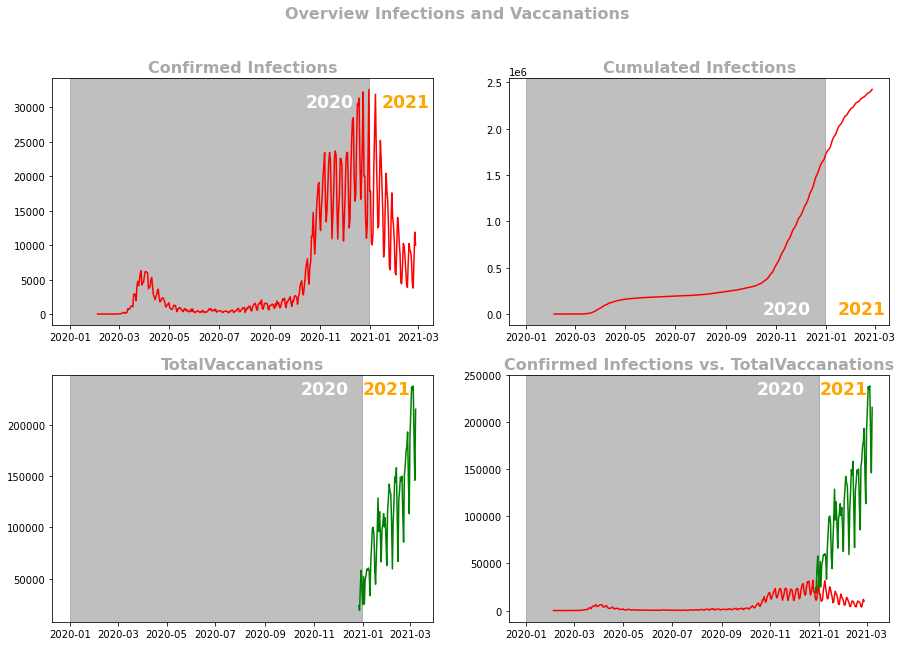

In [65]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Overview Infections and Vaccanations',fontsize=16,
            fontweight='bold',
            color='darkgrey')

ax1=ax[0,0]
ax1.plot(df_ref_hos_ger_obs['date'],df_ref_hos_ger_obs['confirmed_infections'],color='red')
ax1.axvspan(datetime.date(2020,1,1),datetime.date(2020,12,31),color='grey',alpha=.5)
ax1.text(x=datetime.date(2020,10,15),y=30000,s='2020',color='white',fontsize='xx-large',fontweight='bold')
ax1.text(x=datetime.date(2021,1,15),y=30000,s='2021',color='orange',fontsize='xx-large',fontweight='bold')
ax1.set_title(label='Confirmed Infections',fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'})


ax2=ax[0,1]
ax2.plot(infecctions_cum,color='red')
ax2.axvspan(datetime.date(2020,1,1),datetime.date(2020,12,31),color='grey',alpha=.5)
ax2.text(x=datetime.date(2020,10,15),y=2,s='2020',color='white',fontsize='xx-large',fontweight='bold')
ax2.text(x=datetime.date(2021,1,15),y=2,s='2021',color='orange',fontsize='xx-large',fontweight='bold')
ax2.set_title(label='Cumulated Infections',fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'})

ax3=ax[1,0]
ax3.plot(vac.index,vac['TotalVaccanations'],color='green')
ax3.axvspan(datetime.date(2020,1,1),datetime.date(2020,12,31),color='grey',alpha=.5)
ax3.text(x=datetime.date(2020,10,15),y=230000,s='2020',color='white',fontsize='xx-large',fontweight='bold')
ax3.text(x=datetime.date(2021,1,1),y=230000,s='2021',color='orange',fontsize='xx-large',fontweight='bold')
ax3.set_title(label='TotalVaccanations',fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'})


ax4=ax[1,1]
ax4.plot(df_ref_hos_ger_obs['date'],df_ref_hos_ger_obs['confirmed_infections'],color='red')
ax4.plot(vac.index,vac['TotalVaccanations'],color='green')
ax4.axvspan(datetime.date(2020,1,1),datetime.date(2020,12,31),color='grey',alpha=.5)
ax4.text(x=datetime.date(2020,10,15),y=230000,s='2020',color='white',fontsize='xx-large',fontweight='bold')
ax4.text(x=datetime.date(2021,1,1),y=230000,s='2021',color='orange',fontsize='xx-large',fontweight='bold')
ax4.set_title(label='Confirmed Infections vs. TotalVaccanations',fontdict={'fontsize':16,'color':'darkgrey','fontweight':'bold'})


#plt.xticks(rotation=90)
#for tick in ax:
 #   plt.xticks(rotation=90)



In [ ]:
#ineplot_func(data=df_ref_hos_ger_obs,x='date',y='deaths_upper',title='Deaths Germany')
#df_ref_hos_ger_obs.info()